**1. Imports & Environment Setup**

---

This cell imports all necessary libraries and modules for the project. We rely on `PyTorch` as the core deep learning framework, `timm` for accessing pre-trained models, and `torchmetrics` for performance evaluation. Supporting libraries such as `NumPy`, `Pandas`, and `Matplotlib` are used for data manipulation and visualization, while `scikit-learn` provides utility functions for tasks like stratified splitting and class weight calculation.


In [ ]:

# --- Standard Library Imports ---
import os
import random
import time
import collections
import math
from typing import Optional, List, Tuple, Dict, Any, Iterable

# --- Core Scientific Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# --- Machine Learning & Deep Learning Libraries ---
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset, WeightedRandomSampler
from torch.optim.lr_scheduler import CosineAnnealingLR #, LinearLR # LinearLR seems unused
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models

# --- Third-party Libraries ---
import timm
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from torchmetrics import Accuracy, Precision, Recall, F1Score, ConfusionMatrix
from tqdm import tqdm


**2. Project Configuration**

---
A centralized class to manage all hyperparameters, file paths, and model settings. This approach ensures reproducibility and allows for easy tuning of experiments by modifying a single, well-documented location.

In [ ]:


class ProjectConfig:
    def __init__(self):
        # ====================================================================
        # // --- Core & Global Setup --- //
        # ====================================================================
        # self.model_type = 'cnn'  # CHANGE HERE: 'vit' or 'cnn'
        self.model_type = 'vit'
        self.seed = 42

        # Paths
        self.data_dir = './chest_xray/'
        self.train_dir = os.path.join(self.data_dir, 'train')
        self.val_dir = os.path.join(self.data_dir, 'val')
        self.test_dir = os.path.join(self.data_dir, 'test')
        self.log_dir = './logs'
        self.tensorboard_log_dir = 'logs/tensorboard'

        # Global parameters
        self.in_channels = 3
        self.num_classes = 2
        self.num_workers = 4
        self.use_class_weights = True
        self.use_tensorboard = True
        self.compute_param_count = True
        self.norm_mean = [0.485, 0.456, 0.406]
        self.norm_std = [0.229, 0.224, 0.225]

        # --- THIS IS THE CORRECTED PART ---
        # Global data augmentation parameters (restored)
        self.resize_margin = 32
        self.rotation_degrees = 15
        self.crop_scale_min = 0.8
        self.crop_scale_max = 1.0
        # --- END OF CORRECTION ---

        # ====================================================================
        # // --- ViT: Architecture & Training Strategy --- //
        # ====================================================================
        self.VIT_model_save_path = './models/best_model_vit.pth'
        self.VIT_pretrained = True
        self.VIT_patch_size = 16
        self.VIT_embed_dim = 768
        self.VIT_depth = 12
        self.VIT_num_heads = 12
        self.VIT_mlp_dim = 3072
        self.VIT_image_size = 224
        self.VIT_use_strong_aug = True
        self.VIT_batch_size = 32
        self.VIT_num_epochs = 12
        self.VIT_learning_rate = 1e-4
        self.VIT_weight_decay = 0.3
        self.VIT_dropout = 0.1
        self.VIT_scheduler_type = 'cosine'
        self.VIT_warmup_epochs = 5
        self.VIT_min_lr = 1e-6

        # ====================================================================
        # // --- CNN: Architecture & Training Strategy --- //
        # ====================================================================
        self.CNN_model_save_path = './models/best_model_cnn.pth'
        self.CNN_base = 'resnet18'
        self.CNN_pretrained = True
        self.CNN_image_size = 224
        self.CNN_use_strong_aug = True
        self.CNN_batch_size = 64
        self.CNN_num_epochs = 15
        self.CNN_learning_rate = 1e-4
        self.CNN_weight_decay = 0.1
        self.CNN_dropout = 0.5
        self.CNN_scheduler_type = 'cosine'
        self.CNN_warmup_epochs = 3
        self.CNN_min_lr = 1e-6

**3. Data Module: Loading & Preprocessing**

---

This cell defines the `PneumoniaDataModule`, which encapsulates all data-related logic. It handles the entire pipeline from loading the raw images to serving them in batches for training.

Key responsibilities include:
- **Defining Data Augmentations:** Applying a set of transformations to the training data to improve model generalization.
- **Data Splitting:** Loading the training data and performing a stratified 80/20 split to create a robust validation set.
- **Handling Class Imbalance:** Calculating class weights and creating a `WeightedRandomSampler` to ensure the model is exposed to a balanced view of the data during training.
- **Creating DataLoaders:** Providing convenient methods to access the training, validation, and test data loaders.

In [ ]:

class PneumoniaDataModule:
    """
    Manages all data loading, preprocessing, and batching operations for the
    pneumonia classification task. It dynamically adjusts parameters based on the model type.
    """
    def __init__(self, config: ProjectConfig):
        """
        Initializes the DataModule.
        Args:
            config (ProjectConfig): A configuration object with all necessary parameters.
        """
        self.config = config
        self.train_dataset = None
        self.val_dataset = None
        self.test_dataset = None
        self.class_counts = None
        self.train_sample_weights = None

    def setup(self):
        """
        Defines transformations, loads datasets, performs splits, and prepares samplers.
        Dynamically selects data parameters based on the config.model_type.
        """
        if self.config.model_type == 'vit':
            image_size = self.config.VIT_image_size
            use_strong_aug = self.config.VIT_use_strong_aug
        elif self.config.model_type == 'cnn':
            image_size = self.config.CNN_image_size
            use_strong_aug = self.config.CNN_use_strong_aug
        else:
            raise ValueError(f"Invalid model_type in config: {self.config.model_type}")

        # Training transforms are now built using the selected parameters
        train_transforms_list = [
            transforms.Resize((image_size + self.config.resize_margin, image_size + self.config.resize_margin)),
            transforms.RandomResizedCrop(image_size, scale=(self.config.crop_scale_min, self.config.crop_scale_max)),
            transforms.RandomHorizontalFlip(),
            transforms.RandomRotation(self.config.rotation_degrees),
        ]

        if use_strong_aug:
            train_transforms_list.extend([
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomAffine(degrees=0, shear=10, scale=(0.9, 1.1))
            ])

        train_transforms_list.extend([
            transforms.ToTensor(),
            transforms.Normalize(mean=self.config.norm_mean, std=self.config.norm_std)
        ])
        train_transform = transforms.Compose(train_transforms_list)

        val_test_transform = transforms.Compose([
            transforms.Resize(image_size + 32),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
            transforms.Normalize(mean=self.config.norm_mean, std=self.config.norm_std)
        ])

        # The rest of the setup function remains the same as it uses the local variables
        full_train_dataset = datasets.ImageFolder(self.config.train_dir, transform=train_transform)
        self.test_dataset = datasets.ImageFolder(self.config.test_dir, transform=val_test_transform)

        indices = list(range(len(full_train_dataset)))
        labels = full_train_dataset.targets
        train_indices, val_indices = train_test_split(
            indices, test_size=0.2, stratify=labels, random_state=self.config.seed
        )

        self.train_dataset = Subset(full_train_dataset, train_indices)
        self.val_dataset = Subset(full_train_dataset, val_indices)
        self.val_dataset.dataset.transform = val_test_transform

        train_targets = [labels[i] for i in train_indices]
        counter = collections.Counter(train_targets)
        self.class_counts = [counter[i] for i in range(self.config.num_classes)]
        print(f"[DATA] Training class counts (after split): {dict(enumerate(self.class_counts))}")

        class_weights = 1.0 / torch.tensor(self.class_counts, dtype=torch.float)
        self.train_sample_weights = class_weights[train_targets]


    def _get_dataloader(self, dataset, shuffle=False, sampler=None):
        """Helper function to create a DataLoader with reproducible workers."""

        if self.config.model_type == 'vit':
            batch_size = self.config.VIT_batch_size
        elif self.config.model_type == 'cnn':
            batch_size = self.config.CNN_batch_size
        else:
            raise ValueError(f"Invalid model_type in config: {self.config.model_type}")

        def worker_init_fn(worker_id):
            np.random.seed(self.config.seed + worker_id)
            random.seed(self.config.seed + worker_id)

        return DataLoader(
            dataset,
            batch_size=batch_size, # Use the selected batch_size
            shuffle=shuffle,
            sampler=sampler,
            num_workers=self.config.num_workers,
            pin_memory=True,
            worker_init_fn=worker_init_fn
        )

    def train_dataloader(self):
        """Returns the DataLoader for the training set with a weighted sampler."""
        sampler = WeightedRandomSampler(self.train_sample_weights, len(self.train_sample_weights), replacement=True)
        return self._get_dataloader(self.train_dataset, shuffle=False, sampler=sampler)

    def val_dataloader(self):
        """Returns the DataLoader for the validation set."""
        return self._get_dataloader(self.val_dataset, shuffle=False)

    def test_dataloader(self):
        """Returns the DataLoader for the test set."""
        return self._get_dataloader(self.test_dataset, shuffle=False)

    def get_class_counts(self):
        """Returns the computed class counts for the training set."""
        if self.class_counts is None:
            raise ValueError("Must call setup() before getting class counts.")
        return self.class_counts

**4. Model Architecture: Vision Transformer (ViT) - Helper Modules**

---

This cell contains the fundamental building blocks of the Vision Transformer architecture. These modules are defined separately for clarity and modularity, following the structure proposed in the paper "An Image is Worth 16x16 Words" (Dosovitskiy et al., 2020).

- **`PatchEmbedding`**: Converts an image into a sequence of flattened, linearly projected patches.
- **`MultiHeadAttention`**: Implements the scaled dot-product self-attention mechanism across multiple heads.
- **`TransformerEncoderLayer`**: A single encoder block, combining multi-head attention and an MLP with residual connections.

In [ ]:

class PatchEmbedding(nn.Module):
    """
    Converts a 2D image into a 1D sequence of token embeddings.

    This is achieved efficiently by using a Conv2d layer with a kernel size and stride
    equal to the patch size.
    """
    def __init__(self, image_size: int, patch_size: int, in_channels: int, embed_dim: int):
        super().__init__()
        self.patch_size = patch_size
        self.num_patches = (image_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): Input image tensor of shape (B, C, H, W).
        Returns:
            torch.Tensor: Sequence of patch embeddings of shape (B, num_patches, embed_dim).
        """
        x = self.proj(x)  # (B, embed_dim, H_patch, W_patch)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

class MultiHeadAttention(nn.Module):
    """
    Multi-Head Self-Attention module.

    It projects the input into queries, keys, and values, then applies scaled
    dot-product attention independently across multiple heads before combining the results.
    """
    def __init__(self, embed_dim: int, num_heads: int, dropout: float = 0.1):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        B, N, C = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv.unbind(0)

        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)
        return x

class TransformerEncoderLayer(nn.Module):
    """
    A single layer of the Transformer Encoder.

    It consists of a Multi-Head Self-Attention block followed by an MLP block.
    Pre-LayerNorm and residual connections are used.
    """
    def __init__(self, embed_dim: int, num_heads: int, mlp_dim: int, dropout: float = 0.1):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadAttention(embed_dim, num_heads, dropout)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, mlp_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(mlp_dim, embed_dim),
            nn.Dropout(dropout)
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

**5a. Model Architecture: Vision Transformer (ViT) - Main Class**

---

This cell defines the main `VisionTransformer` class, which assembles the helper modules into the full architecture. It supports two modes, controlled by the `vit_pretrained` flag in the `ProjectConfig`:

1.  **Pre-trained Mode**: Loads a `vit_base_patch16_224` model from the `timm` library with pre-trained ImageNet weights. It then freezes the initial layers for stable transfer learning.
2.  **From-Scratch Mode**: Builds the ViT architecture from the ground up using our defined helper modules and initializes the weights.

In [ ]:

class VisionTransformer(nn.Module):
    """
    Vision Transformer (ViT) model for image classification.
    """
    def __init__(self, config: ProjectConfig):
        super().__init__()
        self.config = config

        # --- Mode 1: Load a pre-trained model for transfer learning ---
        if config.VIT_pretrained:
            self.model = timm.create_model(
                'vit_base_patch16_224',
                pretrained=True,
                num_classes=config.num_classes
            )
            print("[MODEL] Loaded pre-trained ViT-Base from timm.")

            # Freeze the patch embedding and the first few transformer blocks for stability
            self._freeze_layers()

        # --- Mode 2: Build the model from scratch using VIT-specific parameters ---
        else:
            self.model = None # Ensure self.model does not exist in this mode

            # Using VIT_ prefixed parameters from the config
            self.patch_embed = PatchEmbedding(
                config.VIT_image_size,
                config.VIT_patch_size,
                config.in_channels,
                config.VIT_embed_dim
            )
            self.cls_token = nn.Parameter(torch.zeros(1, 1, config.VIT_embed_dim))
            self.pos_embed = nn.Parameter(torch.zeros(1, self.patch_embed.num_patches + 1, config.VIT_embed_dim))
            self.dropout = nn.Dropout(config.VIT_dropout)

            self.layers = nn.ModuleList([
                TransformerEncoderLayer(
                    config.VIT_embed_dim,
                    config.VIT_num_heads,
                    config.VIT_mlp_dim,
                    config.VIT_dropout
                )
                for _ in range(config.VIT_depth)
            ])

            self.norm = nn.LayerNorm(config.VIT_embed_dim)
            self.head = nn.Linear(config.VIT_embed_dim, config.num_classes)

            self._init_weights()

    def _freeze_layers(self):
        """Freezes the initial layers of the pre-trained model."""
        if not hasattr(self, 'model') or self.model is None:
            return

        for param in self.model.patch_embed.parameters():
            param.requires_grad = False

        num_layers_to_freeze = 3
        for i in range(num_layers_to_freeze):
            for param in self.model.blocks[i].parameters():
                param.requires_grad = False

        print(f"[MODEL] Frozen patch embedding and first {num_layers_to_freeze} transformer layers.")

    def _init_weights(self):
        """Initializes weights for the from-scratch model."""
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=.02)
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.LayerNorm):
                nn.init.constant_(m.bias, 0)
                nn.init.constant_(m.weight, 1.0)

        nn.init.trunc_normal_(self.pos_embed, std=.02)
        nn.init.trunc_normal_(self.cls_token, std=.02)
        print("[MODEL] Weights initialized for from-scratch training.")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        if hasattr(self, 'model') and self.model is not None:
            return self.model(x)

        else:
            B = x.shape[0]
            x = self.patch_embed(x)

            cls_tokens = self.cls_token.expand(B, -1, -1)
            x = torch.cat((cls_tokens, x), dim=1)

            x = x + self.pos_embed
            x = self.dropout(x)

            for layer in self.layers:
                x = layer(x)

            x = self.norm(x)

            cls_token_output = x[:, 0]
            return self.head(cls_token_output)

**5b. Model Architecture: Convolutional Neural Network (CNN)**

---

This cell defines the `CNNModel` class, which serves as the second model for our comparative analysis. Following the same transfer learning paradigm as the ViT, this model leverages a pre-trained architecture to solve the pneumonia classification task.

The implementation uses a **ResNet** model from `torchvision`, pre-trained on ImageNet. The final fully-connected layer of the network is replaced with a new layer tailored to our binary classification problem.

In [ ]:

class CNNModel(nn.Module):
    """
    A Convolutional Neural Network (CNN) model for image classification,
    built using a pre-trained ResNet backbone from torchvision.
    """
    def __init__(self, config: ProjectConfig):
        """
        Initializes the CNN model.

        Args:
            config (ProjectConfig): The configuration object containing model settings.
        """
        super().__init__()
        self.config = config

        # 1. Load the pre-trained base model using the CNN_ prefixed variables
        # The specific model (e.g., 'resnet18') is defined in the config
        if self.config.CNN_base == 'resnet18':
            self.base_model = models.resnet18(weights='IMAGENET1K_V1')
        elif self.config.CNN_base == 'resnet34':
            self.base_model = models.resnet34(weights='IMAGENET1K_V1')
        # You can add more options here, e.g., resnet50
        else:
            raise ValueError(f"Unsupported CNN base model: {self.config.CNN_base}")

        print(f"[MODEL] Loaded pre-trained {self.config.CNN_base} from torchvision.")
        # 2. Replace the final classification layer (the 'head')
        # Get the number of input features for the last layer
        num_ftrs = self.base_model.fc.in_features

        # Create a new final layer for our binary classification task
        self.base_model.fc = nn.Sequential(
            nn.Dropout(p=self.config.CNN_dropout, inplace=True),
            nn.Linear(num_ftrs, self.config.num_classes)
        )

        print(f"[MODEL] Replaced the final classification layer for {self.config.num_classes} classes.")

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Defines the forward pass of the model.
        """
        return self.base_model(x)



**6. The Trainer Class**

---
This cell contains the `Trainer` class, which orchestrates the entire model training and validation process. It is designed to be generic and can handle different models (ViT, CNN) and configurations.

Upon initialization, it reads the `model_type` from the config and selects the appropriate set of hyperparameters (`VIT_` or `CNN_` prefixed). This allows the rest of the training logic to remain clean and independent of the specific model being trained.

In [ ]:

class Trainer:
    """
    Orchestrates the training, validation, and evaluation loops for a model.
    """
    def __init__(self, model: nn.Module, data_module: PneumoniaDataModule, config: ProjectConfig, loss_fn: nn.Module):
        """
        Initializes the Trainer.
        """
        self.model = model
        self.data_module = data_module
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model.to(self.device)

        assert loss_fn is not None, "A loss function must be provided to the Trainer."
        self.loss_fn = loss_fn

        # Select model-specific hyperparameters
        if config.model_type == 'vit':
            self.learning_rate = config.VIT_learning_rate
            self.weight_decay = config.VIT_weight_decay
            self.num_epochs = config.VIT_num_epochs
            self.warmup_epochs = config.VIT_warmup_epochs
            self.model_save_path = config.VIT_model_save_path
            self.scheduler_type = config.VIT_scheduler_type
            self.min_lr = config.VIT_min_lr
        elif config.model_type == 'cnn':
            self.learning_rate = config.CNN_learning_rate
            self.weight_decay = config.CNN_weight_decay
            self.num_epochs = config.CNN_num_epochs
            self.warmup_epochs = config.CNN_warmup_epochs
            self.model_save_path = config.CNN_model_save_path
            self.scheduler_type = config.CNN_scheduler_type
            self.min_lr = config.CNN_min_lr
        else:
            raise ValueError(f"Invalid model_type in config: {config.model_type}")

        # Metrics and History Tracking
        self.accuracy_metric = Accuracy(task='multiclass', num_classes=self.config.num_classes).to(self.device)
        self.train_losses, self.val_losses, self.train_accs, self.val_accs = [], [], [], []

        # Early Stopping & Checkpointing
        self.best_val_loss = float('inf')
        self.patience_counter = 0
        self.patience = 3
        self.delta = 0.001

        # Optimizer & Scheduler
        self.optimizer = optim.AdamW(self.model.parameters(), lr=self.learning_rate, weight_decay=self.weight_decay)
        self.scheduler = CosineAnnealingLR(
            self.optimizer,
            T_max=(self.num_epochs - self.warmup_epochs),
            eta_min=self.min_lr
        ) if self.scheduler_type == 'cosine' else None

        # Logging
        self.writer = SummaryWriter(log_dir=self.config.tensorboard_log_dir) if self.config.use_tensorboard else None
        if self.writer:
            print("[TRAINER] TensorBoard writer initialized.")

    def _optimize_step(self, inputs: torch.Tensor, labels: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
        outputs = self.model(inputs)
        loss = self.loss_fn(outputs, labels)
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        return loss, outputs

    def _run_epoch(self, dataloader: DataLoader, is_training: bool = True) -> Tuple[float, float]:
        self.model.train() if is_training else self.model.eval()
        running_loss = 0.0
        self.accuracy_metric.reset()
        desc = "Training" if is_training else "Validation"

        for inputs, labels in tqdm(dataloader, desc=desc):
            inputs, labels = inputs.to(self.device), labels.to(self.device)
            if is_training:
                loss, outputs = self._optimize_step(inputs, labels)
            else:
                with torch.no_grad():
                    outputs = self.model(inputs)
                    loss = self.loss_fn(outputs, labels)
            running_loss += loss.item()
            preds = outputs.argmax(dim=1)
            self.accuracy_metric.update(preds, labels)

        avg_loss = running_loss / len(dataloader) if len(dataloader) > 0 else 0.0
        avg_acc = self.accuracy_metric.compute().item()
        return avg_loss, avg_acc

    def fit(self):
        print(f"[TRAINER] Starting training for {self.config.model_type.upper()} model...")
        self.data_module.setup()
        train_loader = self.data_module.train_dataloader()
        val_loader = self.data_module.val_dataloader()

        for epoch in range(self.num_epochs):
            print(f"\nEpoch {epoch+1}/{self.num_epochs}")

            if epoch < self.warmup_epochs:
                lr_scale = (epoch + 1) / self.warmup_epochs
                for g in self.optimizer.param_groups:
                    g['lr'] = self.learning_rate * lr_scale
                print(f"[SCHED] Warmup LR: {self.optimizer.param_groups[0]['lr']:.6f}")

            train_loss, train_acc = self._run_epoch(train_loader, is_training=True)
            val_loss, val_acc = self._run_epoch(val_loader, is_training=False)

            self.train_losses.append(train_loss); self.val_losses.append(val_loss)
            self.train_accs.append(train_acc); self.val_accs.append(val_acc)

            print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
            print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

            if val_loss < self.best_val_loss - self.delta:
                print(f"Validation loss improved from {self.best_val_loss:.4f} to {val_loss:.4f}.")
                self.best_val_loss = val_loss
                self.patience_counter = 0

                os.makedirs(os.path.dirname(self.model_save_path), exist_ok=True)
                torch.save(self.model.state_dict(), self.model_save_path)
                print(f"Best model saved to {self.model_save_path}")
            else:
                self.patience_counter += 1
                print(f"[EARLY STOP] No improvement (counter: {self.patience_counter}/{self.patience})")
                if self.patience_counter >= self.patience:
                    print(f"[EARLY STOP] Stopping training at epoch {epoch+1}")
                    break

            current_lr = self.optimizer.param_groups[0]['lr']
            if self.scheduler and epoch >= self.warmup_epochs:
                self.scheduler.step()
                current_lr = self.scheduler.get_last_lr()[0]
                print(f"[SCHED] LR updated to: {current_lr:.6f}")

            if self.writer:
                self.writer.add_scalar('Train/Loss', train_loss, epoch)
                self.writer.add_scalar('Train/Accuracy', train_acc, epoch)
                self.writer.add_scalar('Val/Loss', val_loss, epoch)
                self.writer.add_scalar('Val/Accuracy', val_acc, epoch)
                self.writer.add_scalar('Learning_Rate', current_lr, epoch)

        if self.writer: self.writer.close()
        print("[TRAINER] Training finished.")

**7. Evaluation Function**

---

This cell contains the main evaluation function, `evaluate_on_test`. It is called after training is complete to assess the final model's performance on the unseen test set.

The function is responsible for:
- Loading the best saved model checkpoint.
- Iterating through the test data.
- Calculating a comprehensive set of metrics, including overall (macro-averaged) and per-class performance.
- Displaying the results in a clear table and generating a comparative bar plot.

In [ ]:

def evaluate_on_test(config: ProjectConfig, data_module: PneumoniaDataModule, loss_fn: nn.Module):
    """
    Evaluates the best model on the test set, computes metrics, and displays results.
    """
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    if config.model_type == 'vit':
        model = VisionTransformer(config)
        model_path = config.VIT_model_save_path

    elif config.model_type == 'cnn':
        model = CNNModel(config)
        model_path = config.CNN_model_save_path

    else:
        raise ValueError(f"Invalid model_type in config: {config.model_type}")

    try:
        model.load_state_dict(torch.load(model_path))
        model.to(device)
        model.eval()
        print(f"[EVAL] Loaded best {config.model_type.upper()} model from {model_path} for test evaluation.")
    except FileNotFoundError:
        print(f"[ERROR] Could not find the model file at the specified path: {model_path}")
        print("Please ensure that the model was trained and saved correctly.")
        return # Exit the function if the model can't be loaded

    # 2. Get test loader
    test_loader = data_module.test_dataloader()

    # 3. Initialize metrics (The rest of the function remains the same...)
    accuracy = Accuracy(task='multiclass', num_classes=2).to(device)
    precision_macro = Precision(task='multiclass', average='macro', num_classes=2).to(device)
    recall_macro = Recall(task='multiclass', average='macro', num_classes=2).to(device)
    f1_macro = F1Score(task='multiclass', average='macro', num_classes=2).to(device)

    precision_per_class = Precision(task='multiclass', average='none', num_classes=2).to(device)
    recall_per_class = Recall(task='multiclass', average='none', num_classes=2).to(device)
    f1_per_class = F1Score(task='multiclass', average='none', num_classes=2).to(device)

    # 4. Run evaluation loop...
    test_loss = 0.0
    with torch.no_grad():
        for inputs, labels in tqdm(test_loader, desc="Test Evaluation"):
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            test_loss += loss_fn(outputs, labels).item()
            preds = outputs.argmax(dim=1)

            accuracy.update(preds, labels)
            precision_macro.update(preds, labels)
            recall_macro.update(preds, labels)
            f1_macro.update(preds, labels)
            precision_per_class.update(preds, labels)
            recall_per_class.update(preds, labels)
            f1_per_class.update(preds, labels)

    # 5. Compute and display final metrics...
    avg_test_loss = test_loss / len(test_loader)

    test_acc = accuracy.compute().item()
    test_precision = precision_macro.compute().item()
    test_recall = recall_macro.compute().item()
    test_f1 = f1_macro.compute().item()

    per_class_precision = precision_per_class.compute().cpu().numpy()
    per_class_recall = recall_per_class.compute().cpu().numpy()
    per_class_f1 = f1_per_class.compute().cpu().numpy()

    print("\n--- Overall Test Results ---")
    print(f"Test Loss: {avg_test_loss:.4f}")
    print(f"Accuracy: {test_acc:.4f} ({test_acc:.2%})")
    print(f"Precision (Macro): {test_precision:.4f}")
    print(f"Recall (Macro): {test_recall:.4f}")
    print(f"F1-Score (Macro): {test_f1:.4f}")

    classes = ['NORMAL (Class 0)', 'PNEUMONIA (Class 1)']
    df = pd.DataFrame({
        'Class': classes,
        'Precision': [f"{p:.4f} ({p:.2%})" for p in per_class_precision],
        'Recall': [f"{r:.4f} ({r:.2%})" for r in per_class_recall],
        'F1-Score': [f"{f:.4f} ({f:.2%})" for f in per_class_f1]
    })
    print("\n--- Per-Class Metrics ---")
    print(df.to_string(index=False))

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    width = 0.25
    x = np.arange(len(classes))
    ax.bar(x - width, per_class_precision, width, label='Precision')
    ax.bar(x, per_class_recall, width, label='Recall')
    ax.bar(x + width, per_class_f1, width, label='F1-Score')
    ax.set_xticks(x)
    ax.set_xticklabels(classes)
    ax.set_ylabel('Score')
    ax.set_title('Per-Class Metrics on Test Set')
    ax.legend()
    plt.tight_layout()
    plt.show()

**8. Main Execution: Setup & Initialization**

---

This cell serves as the main entry point for the script. It performs the initial setup by:
1.  Instantiating the `ProjectConfig` class to load all hyperparameters.
2.  Configuring the environment for reproducible results by setting seeds for all relevant libraries.
3.  Initializing the `PneumoniaDataModule` and calling its `setup()` method to prepare the datasets.

In [ ]:
# 1. Instantiate the ProjectConfig
config = ProjectConfig()
print(f"[BOOT] Loaded configuration. Model type: {config.model_type.upper()}")

# 2. Set up environment for reproducibility
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # For better error messages from CUDA
os.environ['CUBLAS_WORKSPACE_CONFIG'] = ':4096:8'
torch.use_deterministic_algorithms(True)

random.seed(config.seed)
np.random.seed(config.seed)
torch.manual_seed(config.seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(config.seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
print("[BOOT] Environment set for reproducibility.")

# 3. Prepare the data
data_module = PneumoniaDataModule(config)
data_module.setup()
print("[BOOT] Data module prepared and setup completed.")

[BOOT] Loaded configuration. Model type: VIT
[BOOT] Environment set for reproducibility.
[DATA] Training class counts (after split): {0: 1073, 1: 3099}
[BOOT] Data module prepared and setup completed.


**9. Main Execution: Model, Loss, and Trainer Setup**

---

This cell prepares all the components required for training:
1.  The appropriate model (`VisionTransformer` or `CNNModel`) is instantiated based on the `model_type` in the config.
2.  The loss function (`CrossEntropyLoss` with class weights) is defined.
3.  The `Trainer` class is instantiated with the model, data, config, and loss function.

In [ ]:
# This block is intended to be run in a single cell in a Jupyter Notebook.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. Instantiate the model based on config.model_type
if config.model_type == 'vit':
    model = VisionTransformer(config)
elif config.model_type == 'cnn':
    model = CNNModel(config) # Assumes CNNModel is defined
else:
    raise ValueError(f"Invalid model_type in config: {config.model_type}")

model.to(device)
print(f"[BOOT] Model built: {type(model).__name__}")

# (Optional) Compute and log parameter count
if config.compute_param_count:
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"[BOOT] Trainable parameters: {total_params:,}")

# 2. Define the loss function
class_counts = data_module.get_class_counts()
class_weights = compute_class_weight(
    'balanced',
    classes=np.array([0, 1]),
    y=np.array([0] * class_counts[0] + [1] * class_counts[1])
)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)
loss_fn = nn.CrossEntropyLoss(weight=class_weights)
print(f"[BOOT] Loss function set with class weights: {class_weights.cpu().numpy()}")

# 3. Instantiate the Trainer
trainer = Trainer(model, data_module, config, loss_fn=loss_fn)
print("[BOOT] Trainer initialized.")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


[MODEL] Loaded pre-trained ViT-Base from timm.
[MODEL] Frozen patch embedding and first 3 transformer layers.
[BOOT] Model built: VisionTransformer
[BOOT] Trainable parameters: 63,945,986
[BOOT] Loss function set with class weights: [1.944082  0.6731204]
[TRAINER] TensorBoard writer initialized.
[BOOT] Trainer initialized.


**10. Main Execution: Start Training**

---

This cell executes the main training process by calling the `trainer.fit()` method. The total training time is measured and recorded.

In [ ]:
# This block is intended to be run in a single cell in a Jupyter Notebook.

# Start training and measure the time
print("\n" + "="*50)
print("             STARTING MODEL TRAINING")
print("="*50 + "\n")

start_time = time.time()
trainer.fit()
end_time = time.time()
train_time = end_time - start_time

print("\n" + "="*50)
print(f"      TRAINING COMPLETED in {train_time / 60:.2f} minutes")
print("="*50 + "\n")


             STARTING MODEL TRAINING

[TRAINER] Starting training for VIT model...
[DATA] Training class counts (after split): {0: 1073, 1: 3099}

Epoch 1/12
[SCHED] Warmup LR: 0.000020


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.59it/s]


Train Loss: 0.1011, Train Acc: 0.9432
Val Loss: 0.0790, Val Acc: 0.9684
Validation loss improved from inf to 0.0790.
Best model saved to ./models/best_model_vit.pth

Epoch 2/12
[SCHED] Warmup LR: 0.000040


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.61it/s]


Train Loss: 0.0686, Train Acc: 0.9669
Val Loss: 0.2144, Val Acc: 0.9042
[EARLY STOP] No improvement (counter: 1/3)

Epoch 3/12
[SCHED] Warmup LR: 0.000060


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.65it/s]


Train Loss: 0.0528, Train Acc: 0.9772
Val Loss: 0.1871, Val Acc: 0.9023
[EARLY STOP] No improvement (counter: 2/3)

Epoch 4/12
[SCHED] Warmup LR: 0.000080


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.48it/s]


Train Loss: 0.0490, Train Acc: 0.9787
Val Loss: 0.0708, Val Acc: 0.9693
Validation loss improved from 0.0790 to 0.0708.
Best model saved to ./models/best_model_vit.pth

Epoch 5/12
[SCHED] Warmup LR: 0.000100


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.63it/s]


Train Loss: 0.0413, Train Acc: 0.9777
Val Loss: 0.0823, Val Acc: 0.9789
[EARLY STOP] No improvement (counter: 1/3)

Epoch 6/12


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.55it/s]


Train Loss: 0.0297, Train Acc: 0.9859
Val Loss: 0.1650, Val Acc: 0.9808
[EARLY STOP] No improvement (counter: 2/3)
[SCHED] LR updated to: 0.000095

Epoch 7/12


Validation: 100%|██████████| 33/33 [00:07<00:00,  4.66it/s]

Train Loss: 0.0139, Train Acc: 0.9923
Val Loss: 0.1101, Val Acc: 0.9789
[EARLY STOP] No improvement (counter: 3/3)
[EARLY STOP] Stopping training at epoch 7
[TRAINER] Training finished.

      TRAINING COMPLETED in 8.09 minutes



**11. Main Execution: Post-Training Analysis & Final Evaluation**

---

After training is complete, this cell performs the final analysis:
1.  It plots the training and validation loss and accuracy curves to visualize the learning process.
2.  It calls the `evaluate_on_test` function to get the final performance metrics on the unseen test data.

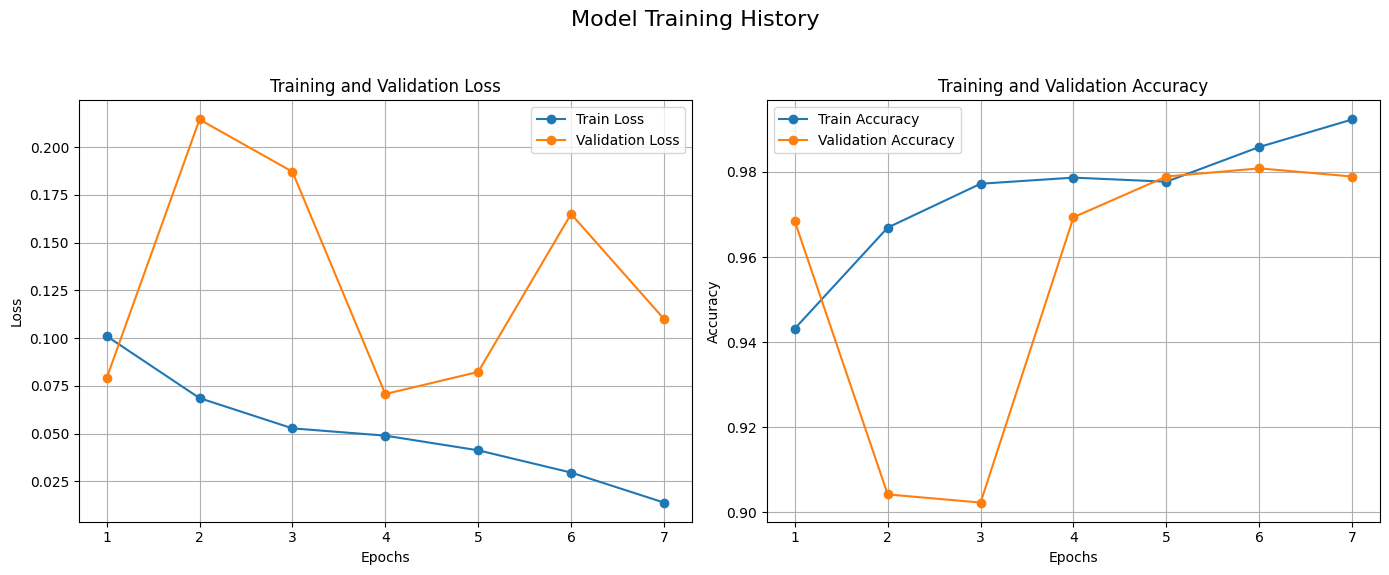

[MODEL] Loaded pre-trained ViT-Base from timm.
[MODEL] Frozen patch embedding and first 3 transformer layers.
[EVAL] Loaded best VIT model from ./models/best_model_vit.pth for test evaluation.


Test Evaluation: 100%|██████████| 20/20 [00:05<00:00,  3.87it/s]



--- Overall Test Results ---
Test Loss: 0.5009
Accuracy: 0.9006 (90.06%)
Precision (Macro): 0.9236
Recall (Macro): 0.8709
F1-Score (Macro): 0.8880

--- Per-Class Metrics ---
              Class       Precision          Recall        F1-Score
   NORMAL (Class 0) 0.9778 (97.78%) 0.7521 (75.21%) 0.8502 (85.02%)
PNEUMONIA (Class 1) 0.8694 (86.94%) 0.9897 (98.97%) 0.9257 (92.57%)


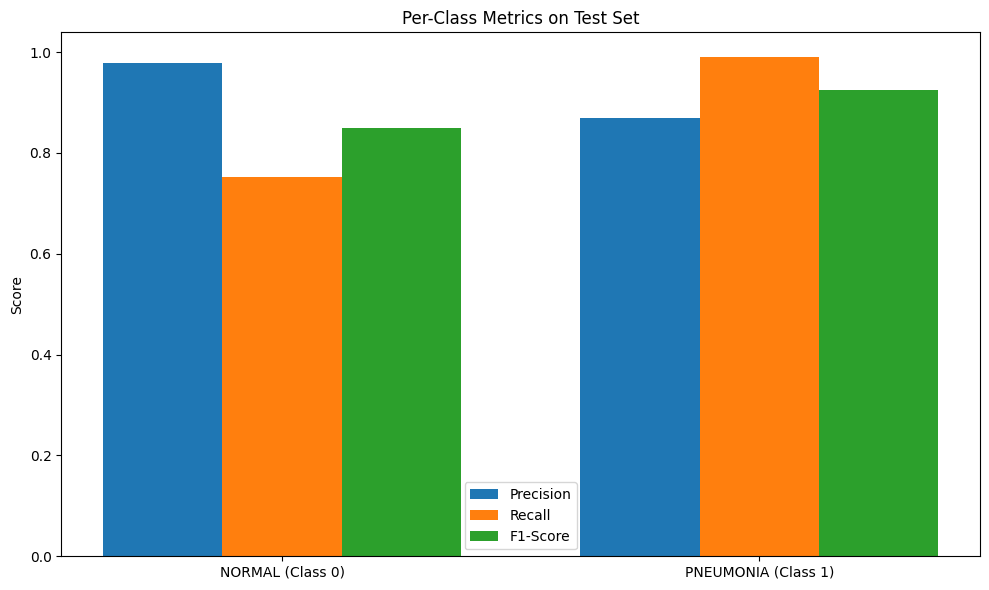

In [74]:
# This block is intended to be run in a single cell in a Jupyter Notebook.

# 1. Plot training and validation curves
epochs_ran = len(trainer.train_losses)
epochs = range(1, epochs_ran + 1)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs, trainer.train_losses, 'o-', label='Train Loss')
plt.plot(epochs, trainer.val_losses, 'o-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(epochs, trainer.train_accs, 'o-', label='Train Accuracy')
plt.plot(epochs, trainer.val_accs, 'o-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)

plt.suptitle('Model Training History', fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# (Optional) Log training time to TensorBoard if a writer was created
if trainer.writer:
    trainer.writer.add_scalar('Training/Total_Time_seconds', train_time)
    trainer.writer.add_figure('Curves/Loss_and_Accuracy', plt.gcf())
    trainer.writer.close() # Close writer after all logging is done

# 2. Evaluate the final model on the test set
evaluate_on_test(config, data_module, loss_fn)